## 알고리즘과 파이프라인


In [1]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터 구성, 분할
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

# 훈련 데이터의 최소값과 최대값 계산
scaler = MinMaxScaler().fit(X_train)

In [2]:
X_train_scaled = scaler.transform(X_train)

In [3]:
svm = SVC()
svm.fit(X_train_scaled, y_train)

SVC()

In [4]:
X_test_scaled = scaler.transform(X_test)
print("테스트 점수 : {:.2f}".format(svm.score(X_test_scaled, y_test)))

테스트 점수 : 0.97


## 데이터 전처리와 매개변수 선택, 파이프라인 구축하기

현재까지 학습을 위해 행한 과정은 MinMaxScaler로 데이터의 스케일을 조정하고 SVM모델을 훈련시키는 work flow를 사용했다. 이러한 워크플로우를 파이프라인으로 구성한다.

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    [
        ("scaler", MinMaxScaler()), 
        ("svm", SVC())
    ]
)

In [6]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [7]:
print("테스트셋 점수 : {:.2f}".format(pipe.score(X_test, y_test)))

테스트셋 점수 : 0.97


## 그리드 서치에 파이프라인 적용하기

탐색할 매개변수 그리드를 정의하고, 이 매개변수 그리드와 파이프라인으로 GridSearchCV 객체를 만든다.

주의할 점으로는 매개변수 그리드 정의 시 PipeLine에서 구성한 모델의 이름을 섞어 매개변수 이름을 정의해야한다.

아래를 참고하자.

In [8]:
param_grid = {
    "svm__C" : [0.001, 0.01, 0.1, 10, 100],
    "svm__gamma" : [0.001, 0.01, 0.1, 1, 10, 100]
}

In [9]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("최상의 교차 검증 정확도 : {:.2f}".format(grid.best_score_))
print("테스트 세트 점수 : {:.2f}".format(grid.score(X_test, y_test)))
print("최적의 매개변수 : ", grid.best_params_)

최상의 교차 검증 정확도 : 0.98
테스트 세트 점수 : 0.97
최적의 매개변수 :  {'svm__C': 100, 'svm__gamma': 0.1}


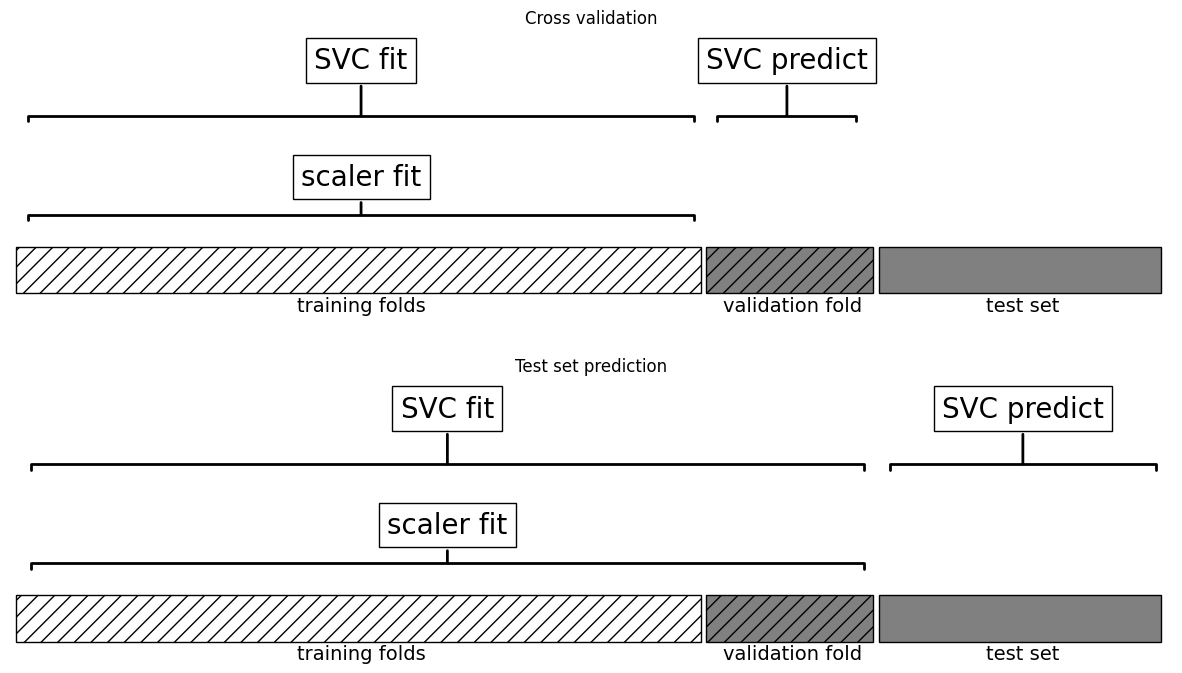

In [10]:
import mglearn

mglearn.plots.plot_proper_processing()

## make_pipeline을 이용한 파이프라인 생성

In [11]:
from sklearn.pipeline import make_pipeline

# 표준적인 방법
pipe_long = Pipeline(
    [
        ("scaler", MinMaxScaler()), 
        ("svm", SVC())
    ]
)

# 간소화된 방법
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

파이프라인 객체 pipe_long과 pipe_short는 정확히 같은 작업을 수행하지만, pipe_short는 단계의 이름을 자동으로 만든다.

In [12]:
pipe_short.steps

[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]

각 단계(step)의 이름은 minmaxscaler와 svc이다. 일반적으로 단계의 이름은 파이썬 클래스 이름의 소문자 버전이다. 같은 파이썬 클래스를 여러 단계에서 사용하게 될 경우 이름 뒤에 숫자가 추가로 붙게된다.

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print(pipe.steps)

[('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


## Step 속성에 접근하기
종종 파이프라인의 단계 중 하나의 속성을 확인하고 싶을 때가 있을 것이다. 단계 이름을 키로 가진 딕셔너리인 `named_steps`속성을 사용하면 파이프라인의 각 단계에 쉽게 접근할 수 있다.

In [14]:
pipe.fit(cancer.data)

Pipeline(steps=[('standardscaler-1', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('standardscaler-2', StandardScaler())])

In [15]:
components = pipe.named_steps["pca"].components_
print("components.shape : ", components.shape)

components.shape :  (2, 30)


## 그리드 서치 안의 파이프라인 속성에 접근하기
스케일 조정을 위한 StandardScaler와 LogisticRegression 분류기로 Pipeline을 만들어 cancer데이터셋에 그리드 서치를 적용한다.

In [16]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

다음으로는 매개변수 그리드를 만듭니다. LogisticRegression의 규제를 조절하는 매개변수는 C이다. 이 매개변수의 범위를 0.01에서 100까지 로그 스케일 단위로 지정한다. 

In [17]:
param_grid = {"logisticregression__C" : [0.01, 0.1, 1, 10, 100]}

In [18]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [19]:
# 최적의 파라미터
print("최적의 파라미터 : ", grid.best_estimator_)

최적의 파라미터 :  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1, max_iter=1000))])


이 경우에 best_estimator_는 standardscaler와 logisticregression 두 단계를 가진 파이프라인이다. logisticregression 단계에 접근하려면, 이전에 한 것 처럼 파이프라인의 named_steps 속성을 사용한다.

In [20]:
print("로지스틱 회귀 단계 : \n", grid.best_estimator_.named_steps['logisticregression'])

로지스틱 회귀 단계 : 
 LogisticRegression(C=1, max_iter=1000)


이제 학습된 LogisticRegression 객체를 얻었기에, 각 입력 특성에 연결된 가중치(계수)를 출력할 수 있다.

In [21]:
print("로지스틱 회귀 계수 : \n", grid.best_estimator_.named_steps['logisticregression'].coef_)

로지스틱 회귀 계수 : 
 [[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


## 전처리와 모델의 매개변수를 위한 그리드 서치

파이프라인을 사용하면 머신러닝 워크플로우에 필요한 모든 처리 단계를 하나의 scikit-learn 추정기로 캡슐화할 수 있다. 또 다른 장점으로, 회귀와 분류같은 지도 학습의 출력을 이용해서 전처리 매개변수를 조정할 수 있다.

In [25]:
from sklearn import datasets
import warnings

warnings.filterwarnings("ignore")

boston = datasets.fetch_openml("boston", return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(boston[0], boston[1], random_state = 0)

In [27]:
X_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
245,0.19133,22.0,5.86,0,0.431,5.605,70.2,7.9549,7,330.0,19.1,389.13,18.46
59,0.10328,25.0,5.13,0,0.453,5.927,47.2,6.9320,8,284.0,19.7,396.90,9.22
276,0.10469,40.0,6.41,1,0.447,7.267,49.0,4.7872,4,254.0,17.6,389.25,6.05
395,8.71675,0.0,18.10,0,0.693,6.471,98.8,1.7257,24,666.0,20.2,391.98,17.12
416,10.83420,0.0,18.10,0,0.679,6.782,90.8,1.8195,24,666.0,20.2,21.57,25.79


In [28]:
y_train.head()

245    18.5
59     19.6
276    33.2
395    13.1
416     7.5
Name: MEDV, dtype: float64

- PolynomialFeatures(다항 회귀)
    + 다항식 및 상호 작용 기능을 생성한다.
    + 지정된 차수보다 작거나 같은 특징의 모든 다항식 조합으로 구성된 새로운 특징 행렬을 생성한다. 예를 들어, 입력 샘플이 2차원이고 [a, b]형식인 경우 2차 다항식 특성은 [1, a, b, a<sup>2</sup>, ab, b<sup>2</sup>]이다.
    + 데이터의 분포가 비선형을 이룰 때 사용한다. 데이터들 간의 형태가 비선형 일 때 데이터에 각 특성의 제곱을 추가해 특성이 추가된 비선형 데이터를 선형 회귀 모델로 훈련시키는 방법이다. 

In [26]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge()
)

다항식의 차수가 얼마나 되어야 할 지, 또는 다항식이나 교차항이 필요한지 어떻게 알 수 있겠는가. 이상적으로는 분류의 결과에 기초해서 degree매개변수를 선택해야 한다. 파이프라인을 사용하면 Ridge의 alpha 매개변수와 함께 degree 매개변수를 탐색할 수 있다. 이렇게 하려면 단계의 접두어로 사용한 매개변수 두 개를 param_grid에 정의해야 한다.

In [29]:
param_grid = {
    "polynomialfeatures__degree" : [1, 2, 3],
    "ridge__alpha" : [0.001, 0.01, 0.1, 1, 10, 100]
}

In [30]:
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

교차검증의 결과를 히트맵을 사용해서 나타낸다.

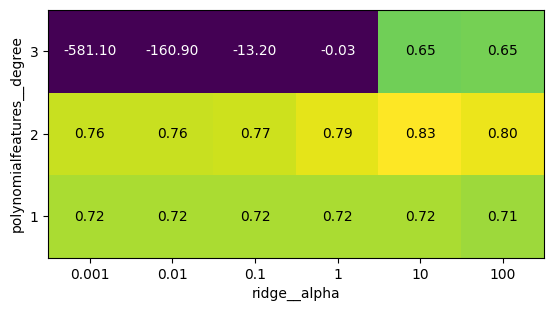

In [31]:
mglearn.tools.heatmap(grid.cv_results_["mean_test_score"].reshape(3, -1),
                      xlabel="ridge__alpha", ylabel="polynomialfeatures__degree",
                      xticklabels=param_grid["ridge__alpha"],
                      yticklabels=param_grid["polynomialfeatures__degree"], vmin=0)

교차검증의 결과를 보면 2차항이 효과가 제일 좋고, 3차는 1, 2차보다 결과가 나쁜것을 확인할 수 있다. 최적의 매개변수를 확인해서도 알 수 있다.


In [33]:
print("최적의 매개변수 : ", grid.best_params_)

최적의 매개변수 :  {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [35]:
# 테스트 점수
print("테스트 셋 점수 : {:.2f}".format(grid.score(X_test, y_test)))

테스트 셋 점수 : 0.77


다항식 특성이 없는 그리드 서치와 비교해보자.

In [39]:
param_grid = {"ridge__alpha" : [0.001, 0.01 , 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

In [40]:
print("다항식 특성이 없는 테스트 점수 : {:.2f}".format(grid.score(X_test, y_test)))

다항식 특성이 없는 테스트 점수 : 0.63


다항 특성이 없는 경우 성능이 저하되는 것을 확인할 수 있다. 모델의 매개변수와 함께 전처리 과정의 매개변수를 찾는 것은 매우 강력한 전략이다.

## 모델 선택을 위한 그리드 서치
GridSearchCV와 Pipeline을 연결하는 것에서 더 나아가, 파이프라인을 구성하는 단계도 탐색 대상으로 삼을 수 있다.

In [42]:
pipe = Pipeline([("preprocessing", StandardScaler()), ("classifier", SVC())])

In [43]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {
        'classifier' : [SVC()],
        'preprocessing' : [StandardScaler()],
        'classifier__gamma' : [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__C' : [0.001, 0.01, 0.1, 1, 10, 100],
    },
    {
        'classifier' : [RandomForestClassifier(n_estimators=100)],
        'preprocessing' : [None],
        'classifier__max_features' : [1, 2, 3]
    }
]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("최적의 매개변수 : \n{}\n".format(grid.best_params_))
print("최상의 교차 검증 점수 : {:.2f}".format(grid.best_score_))
print("테스트 세트 점수 : {:.2f}".format(grid.score(X_test, y_test)))

최적의 매개변수 : 
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

최상의 교차 검증 점수 : 0.99
테스트 세트 점수 : 0.98


위와 같은 과정을 거쳐 한 분류기 내에서 최적의 파라미터를 찾는 것 뿐만 아니라, 여러 분류기의 최적의 파라미터를 찾아 각 분류기 별로 비교하여 최적의 분류기를 찾는 과정 또한 수행할 수 있다.

## 중복 계산 피하기
대규모 그리드 서치를 수행할 때 종종 동일한 단계가 여러 번 수행된다. 예를 들어 classifier의 각 설정에 대해 StandardScaler가 다시 만들어지는 경우가 있다. StandardScaler가 큰 문제는 아니지만 비용이 많이 드는 변환을 사용한다면 계산 낭비가 심해진다. 가장 간단한 해결책은 파이프라인의 memory 매개변수를 사용하여 계산 결과를 캐싱하는 것이다.

In [45]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())], memory='cache_folder')

하지만 이러한 방법은 두 가지 단점이 있다. 

1. 캐시는 디스크에 저장되어 관리되기 때문에 실제 디스크에 읽고 쓰기 위해 직렬화가 필요하다. 즉 비교적 오랜 시간이 걸리는 변환이여야 memory 매개변수를 사용하여 속도를 높이는 효과를 낼 수 있다. 단순히 데이터의 스케일을 변환하는 것이라면 스케일 조정된 데이터를 디스크에서 읽는 것보다 빠를 가능성이 높다. 계산 비용이 높은 변환이라면 그래도 여전히 유용하다.

2. n_jobs 매개변수가 캐싱을 방해한다는 것이다. 그리드 서치의 실행 순서에 따라 최악의 경우 캐시되기 전에 n_jobs만큼의 작업 프로세스가 동시에 동일한 계산을 중복으로 피할 수 있다.

하지만 dask_ml 라이브러리에서 제공하는 GridSearchCV를 사용하면 이런 단점을 모두 피할 수 있다. dask_ml은 병렬 연산을 수행하는 동안 중복된 계산을 방지한다. 심지어 클러스터에 분산된 경우에도 가능하다. 계산 비용이 높은 파이프라인과 방대한 양의 매개변수 탐색을 해야한다면 꼭 dask_ml을 살펴보자.